# Notebook for preprocessing input data for simulation model high resolution

In [1]:
%matplotlib inline
import sys
sys.path.append('project_modules')

# Import libraries for geomatics
import geopandas as gp
from geopy.distance import vincenty, great_circle
from iso3166 import countries
from shapely.geometry import MultiPoint, Polygon, Point, shape

# # Import libraries for visualization
from matplotlib.collections import PatchCollection
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('white')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = 20, 8

# Import libraries for data handling
import pandas as pd
import numpy as np
import random
import networkx as nx


In [2]:
# Convenience functions
def save_fig(fig, directory, name):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.
    
    Parameters
    ----------
    fig : a Figure instance
    dir : str
          the directory where figures are to be saved
    name : str
    
    '''
    plt.savefig('{}/{}_low_res.png'.format(directory, name), dpi=75, 
                                             bbox_inches='tight', transparent=True)
    plt.savefig('{}/{}_hig_res.png'.format(directory, name), dpi=300, 
                                              bbox_inches='tight', transparent=True)   

#### Load geodata with zonal stats and select columns of interest 

In [3]:
gdf_model_elements = gp.read_file('preprocessing_results/geojson/gdf_model_elements.geojson')
gdf_model_elements = gdf_model_elements.set_index('index')

In [4]:
gdf_model_elements.tail(1)

,Crude_Birth_rate,Messinamea,Poverty_WB,adjacmatrix_centrality,continent,country,country_code,geometry,lat,lon,perc_pover,population,pregnancies,suitability_max
index,,,,,,,,,,,,,,
762,19.345307,0.00875,None,0.00939,Asia,West Bank,PSX,"POLYGON ((35.21035935420042 32.54186756286899,...",35.244956,31.945385,17.215887,3.352553e+06,48642.118001,0.192328


In [5]:
gdf_map_elements = gp.read_file('preprocessing_results/geojson/gdf_map_elements.geojson')
import matplotlib_polygon_lst
dict_mapindex_mpl_polygon = matplotlib_polygon_lst.add(gdf_map_elements)

dict_index_country =  gdf_map_elements['country'].to_dict()
dict_country_index = {v: k for k, v in dict_index_country.items()}

# Extract monthly air travel matrix from raw data 

## 1. Air travel data visualization
#### Monthly flows of global air travel passengers for 2010 was extracted from an open-access spatio-temporally resolved statistical models of air passenger flows (Mao et al., 2015).


#### Load travel matrix raw data

In [6]:
Travel_monthly = pd.read_csv(r'raw_data/Flight_data/Travel_monthly/Prediction_Monthly.csv')
Airports_2010 = pd.read_csv(r'raw_data/Flight_data/Travel_monthly/Airports_2010.csv')

Travel_monthly.rename(columns={'\xef\xbb\xbfOrigin': 'Origin'}, inplace=True)
Airports_2010.rename(columns={'NodeName':'airport'}, inplace=True)
Travel_monthly.fillna(0, inplace=True)
Airports_2010.fillna(0, inplace=True)

In [7]:
Travel_monthly.head(1)

,Origin,Dest,Month,Prediction,lower,upper
0,ALC,SOU,1,168,159,177.0


In [8]:
Airports_2010.head(1)

,airport,City,StateCode,CountryCode,Lon,Lat
0,AAA,Anaa,0,PF,-145.42,-17.05


In [9]:
dict_airport_lon = pd.Series(Airports_2010.Lon.values,index=Airports_2010.airport).to_dict()
dict_airport_lat = pd.Series(Airports_2010.Lat.values,index=Airports_2010.airport).to_dict()

Travel_monthly["OriginLat"] = Travel_monthly["Origin"].map(dict_airport_lat)
Travel_monthly["OriginLon"] = Travel_monthly["Origin"].map(dict_airport_lon)
Travel_monthly["DestLat"] = Travel_monthly["Dest"].map(dict_airport_lat)
Travel_monthly["DestLon"] = Travel_monthly["Dest"].map(dict_airport_lon)

Travel_monthly.tail(2)

,Origin,Dest,Month,Prediction,lower,upper,OriginLat,OriginLon,DestLat,DestLon
383046,DAC,ZYL,12,8890,5102,15491.0,23.85,90.41,24.96,91.87
383047,DXB,ZYL,12,768,544,1085.0,25.25,55.35,24.96,91.87


#### Dataset Problem: Duplicates of OD pairs within same month:

In [10]:
Travel_monthly['OD'] = Travel_monthly['Origin']+'_'+Travel_monthly['Dest']
Travel_monthly.groupby('Month').get_group(3)[Travel_monthly.groupby('Month').get_group(3).duplicated('OD')]

,Origin,Dest,Month,Prediction,lower,upper,OriginLat,OriginLon,DestLat,DestLon,OD
104717,MBA,TLS,3,284,268,300.0,-4.03,39.60,43.63,1.37,MBA_TLS
106903,MIA,YHZ,3,185,179,192.0,25.80,-80.28,44.88,-63.51,MIA_YHZ


#### Transform multindex df into dict with months as keys and df as values

In [11]:
Travel_monthly['OD'] = Travel_monthly['Origin']+'_'+Travel_monthly['Dest']
# Travel_monthly.groupby('Month').get_group(3)[Travel_monthly.groupby('Month').get_group(3).duplicated('OD')]
Travel_monthly_dict = {}
for month in range(1, 13):
    # Remove duplicates  of OD pairs within same month: DATASET IMPURITY
    Travel_monthly_dict[month] = Travel_monthly.groupby('Month').get_group(month).drop_duplicates('OD')
Travel_monthly_dict[1].head(1)

,Origin,Dest,Month,Prediction,lower,upper,OriginLat,OriginLon,DestLat,DestLon,OD
0,ALC,SOU,1,168,159,177.0,38.29,-0.56,50.95,-1.36,ALC_SOU


#### Plot global flights using a Great Circle Distance calculation - plot for June

In [12]:
# Adapted from https://github.com/Hugoch/flights-analysis 
# and https://blog.hugo-larcher.com/flight-data-visualisation-with-pandas-and-matplotlib-ebbd13038647#.fi8yu7iha

from matplotlib.colors import Normalize, LinearSegmentedColormap, PowerNorm
from matplotlib.pyplot import imshow 
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

def plot_global_flights(month, color_mode='screen',
             out_filename='flights_map_mpl_I.png', absolute=False):
    """Plots the given CSV data files use matplotlib basemap and saves it to
    a PNG file.

    Args:
        in_filename: Filename of the CSV containing the data points.
        out_filename: Output image filename
        color_mode: Use 'screen' if you intend to use the visualisation for
                    on screen display. Use 'print' to save the visualisation
                    with printer-friendly colors.
        absolute: set to True if you want coloring to depend on your dataset
                  parameter value (ie for comparison).
                  When set to false, each coordinate pair gets a different
                  color.

    """

    if color_mode == 'screen':
        bg_color = (0.0, 0.0, 0, 1.0)
        coast_color = (204/255.0, 0, 153/255.0, 0.7)
        color_list = [(0.0, 0.0, 0.0, 0.0),
                      (204/255.0, 0, 153/255.0, 0.6),
                      (255/255.0, 204/255.0, 230/255.0, 1.0)]
    else:
        bg_color = (1.0, 1.0, 1.0, 1.0)
        coast_color = (10.0/255.0, 10.0/255.0, 10/255.0, 0.8)
        color_list = [(1.0, 1.0, 1.0, 0.0),
                      (255/255.0, 204/255.0, 230/255.0, 1.0),
                      (204/255.0, 0, 153/255.0, 0.6)
                      ]

    routes = Travel_monthly_dict[month] - Travel_monthly_dict[1]
    routes = routes.abs()

    num_routes = len(routes.index)

    # normalize the dataset for color scale
    norm = PowerNorm(0.3, routes['Prediction'].min(),
                     routes['Prediction'].max())
    # norm = Normalize(routes['Prediction'].min(), routes['Prediction'].max())

    # create a linear color scale with enough colors
    if absolute:
        n = routes['Prediction'].max()
    else:
        n = num_routes
    cmap = LinearSegmentedColormap.from_list('cmap_flights', color_list,
                                             N=n)
    # create the map and draw country boundaries
    plt.figure(figsize=(27, 20))
    m = Basemap(projection='mill', lon_0=0)
    m.drawcoastlines(color=coast_color, linewidth=1.0)
    m.fillcontinents(color=bg_color, lake_color=bg_color)
    m.drawmapboundary(fill_color=bg_color)

    # plot each route with its color depending on the number of flights
    for i, route in enumerate(routes.sort_values(by='Prediction',
                              ascending=True).iterrows()):
        route = route[1]
        if absolute:
            color = cmap(norm(int(route['Prediction'])))
        else:
            color = cmap(i * 1.0 / num_routes)

        line, = m.drawgreatcircle(route['OriginLon'], route['OriginLat'],
                                  route['DestLon'], route['DestLat'],
                                  linewidth=0.5, color=color)
        # if the path wraps the image, basemap plots a nasty line connecting
        # the points at the opposite border of the map.
        # we thus detect path that are bigger than 30km and split them
        # by adding a NaN
        path = line.get_path()
        cut_point, = np.where(np.abs(np.diff(path.vertices[:, 0])) > 30000e3)
        if len(cut_point) > 0:
            cut_point = cut_point[0]
            vertices = np.concatenate([path.vertices[:cut_point, :],
                                      [[np.nan, np.nan]],
                                      path.vertices[cut_point+1:, :]])
            path.codes = None  # treat vertices as a serie of line segments
            path.vertices = vertices

    # save the map
    plt.savefig(out_filename, format='png', bbox_inches='tight')
    fig = mpl.pyplot.gcf()
    save_fig(fig, './figs/', 'Flight_data_visualisation_I')


In [13]:
# Takes very longer therefore uncommented
# plot_global_flights(6, 'screen', absolute=True)

In [14]:
# Takes very longer therefore uncommented
# plot_global_flights(6, 'print', absolute=True)

In [15]:
# sns.palplot(sns.cubehelix_palette(5, start=.5, rot=-.75))

#### Create geodataframe from pandas dataframe  to perform spatial join 

In [16]:
create_point = lambda x: Point(x['Lon'], x['Lat'])
Airports_2010['geometry'] = Airports_2010.apply(create_point, axis=1)

geo_df_Airports_2010 = gp.GeoDataFrame(Airports_2010, crs=gdf_model_elements.crs)
geo_df_Airports_2010.head(1)

,airport,City,StateCode,CountryCode,Lon,Lat,geometry
0,AAA,Anaa,0,PF,-145.42,-17.05,POINT (-145.42 -17.05)


#### Create dict that associate airport with region
Note, under the hood geopandas uses libspatialindex (python wrapper rtree) for faster indexing

In [17]:
from geopandas.tools import sjoin
# Ensure that geometries are fine
clean_polygons = lambda x: x.buffer(0) 
gdf_model_elements['geometry'] = gdf_model_elements['geometry'].apply(clean_polygons)

#Spatial join most simple in geopandas - Associate Airport to region
airports_with_region = sjoin(geo_df_Airports_2010, gdf_model_elements, how="inner", op='intersects')

# Efficient way to create a dictionary of two pandas dataframe columns
airport_region_dict = pd.Series(airports_with_region.index_right.values,index=airports_with_region.airport).to_dict()

#Verification
print 'Test airport_region_dict: '            
print ('The airport JAX (Florida) is in the: ', dict_index_country[airport_region_dict['JAX']],\
       'and the airport BKK (Bangkok) is in: ', dict_index_country[airport_region_dict['BKK']])

Test airport_region_dict: 
('The airport JAX (Florida) is in the: ', u'United States of America', 'and the airport BKK (Bangkok) is in: ', u'Thailand')


#### Pivot the airtravel dataset into matrix form where index_rows are the origin and columns are the destination - save in multindex

In [18]:
Travel_monthly_d = {}
for month, df in Travel_monthly_dict.iteritems():
    df_matrix = df.pivot(index='Origin', columns='Dest', values='Prediction')
    df_matrix.index.name = None
    df_matrix.columns.name  = None
    df_matrix = df_matrix[df_matrix.index.isin(list(airport_region_dict.keys()))]
    df_matrix = df_matrix.transpose()
    df_matrix = df_matrix[df_matrix.index.isin(list(airport_region_dict.keys()))]
    df_matrix = df_matrix.transpose()
    
    df_matrix = df_matrix.rename(columns=airport_region_dict, index=airport_region_dict)
    
    df_matrix = df_matrix.groupby(df_matrix.columns, axis=1).sum()
    df_matrix = df_matrix.groupby(df_matrix.index, axis=0).sum()
    
    #Determine missing regions in travel matrix
    missing_regions = [x for x in gdf_model_elements.index.tolist() if x not in df_matrix.index.tolist()]
           
    # Add missing index rows and columns
    df_missing_regions = pd.DataFrame(index=missing_regions, columns=missing_regions)
    df_matrix = pd.concat([df_matrix, df_missing_regions], axis=1)
    
    # Sort columns   
    df_matrix = df_matrix.reindex_axis(sorted(df_matrix.columns), axis=1)
    
    # Replace nan with 0
    df_matrix.fillna(0, inplace=True)

    # Save pandas dataframe for each month in dictionary
    Travel_monthly_d[month] = df_matrix

# Create multindex pandas df from df in dictionary
mulitindex_df_Travel_monthly = pd.concat(Travel_monthly_d.values(),axis=0,keys=Travel_monthly_d.keys())

#### Create graph network from averages of air travel matrix and compute eigenvector. Finally display network as graph and use colormap to visualize the eigenvectors, note the suboptimal visualization, because of great difference of 

Name: ()
Type: Graph
Number of nodes: 640
Number of edges: 2667
Average degree:   8.3344


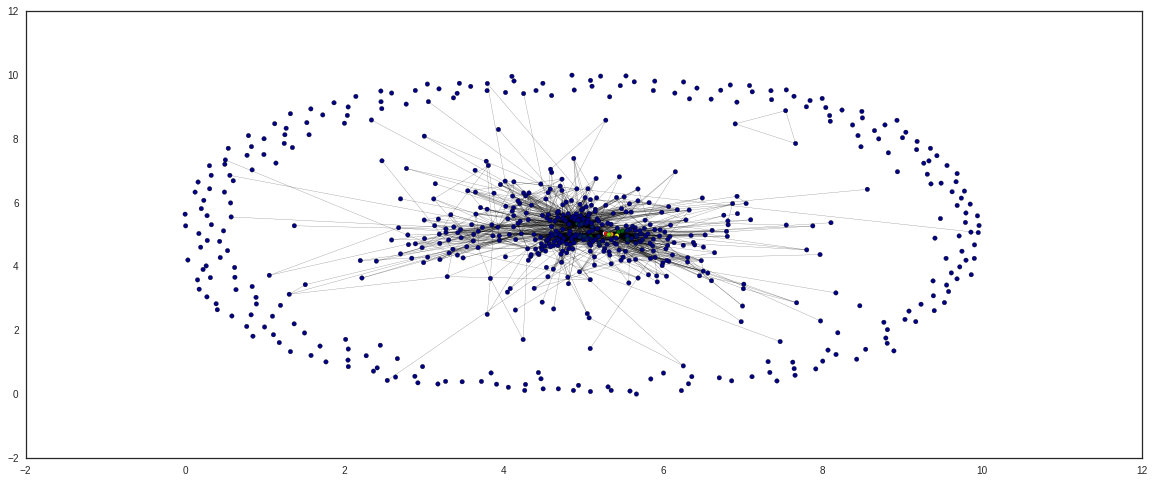

In [19]:
travel_matrix_mean_np = mulitindex_df_Travel_monthly.mean(level=1).values
G_travelmatrix = nx.from_numpy_matrix(travel_matrix_mean_np)
G_travelmatrix = nx.relabel_nodes(G_travelmatrix, dict(enumerate(mulitindex_df_Travel_monthly.ix[3].columns)))

print nx.info(G_travelmatrix)
n_weight = nx.eigenvector_centrality_numpy(G_travelmatrix)
pos =nx.fruchterman_reingold_layout(G_travelmatrix, k=1./.5, scale=10)
nx.draw_networkx_nodes(G_travelmatrix,pos=pos,cmap=plt.get_cmap('gist_ncar'), with_labels=True, node_size=20, node_color=[i*1 for i in n_weight.values()])
nx.draw_networkx_edges(G_travelmatrix,pos=pos, width=.3, alpha=.5);

#### Verification of results: Display smallest and largest Eigenvector of nodes (region)

In [20]:
import operator
min_eigenvector = min(n_weight.iteritems(), key=operator.itemgetter(1))[0]
max_eigenvector = max(n_weight.iteritems(), key=operator.itemgetter(1))[0]
print (dict_index_country[min_eigenvector], dict_index_country[max_eigenvector])

(u'Lesotho', u'United States of America')


#### Bring eigenvector to logarithmic scale for better visualization

In [21]:
# Dirty Fix: Secure that eigenvector is not equal or smaller than zero
for k, v in n_weight.iteritems():
    if v < 0:
        n_weight[k]=0.000000001
        
bins = np.logspace(np.log10(min(n_weight.values())) , np.log10(max(n_weight.values())) , num=20)
digitized = np.digitize(n_weight.values(), bins)

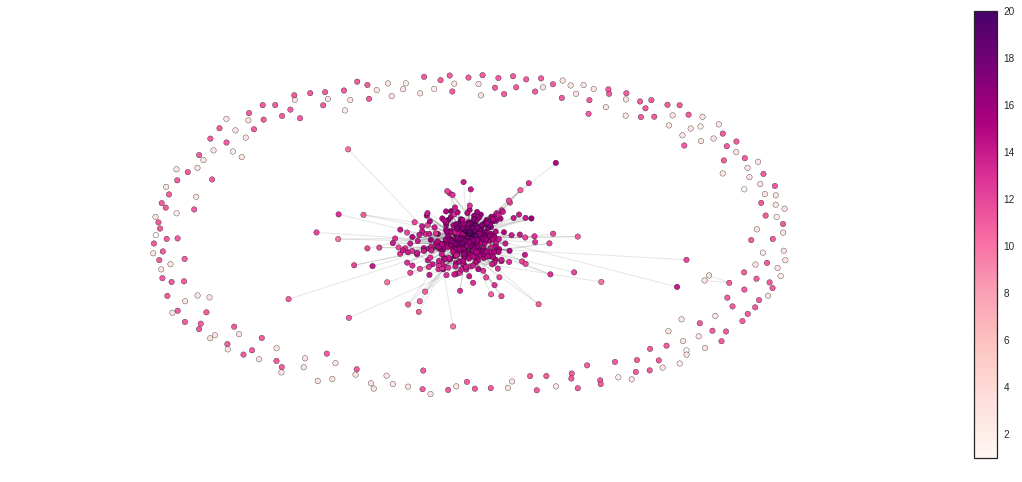

In [22]:
pos =nx.fruchterman_reingold_layout(G_travelmatrix, k=1./1., scale=10)
# pos =nx.random_layout(G)

nc = nx.draw_networkx_nodes(G_travelmatrix,pos=pos,cmap=plt.get_cmap('RdPu'), with_labels=False, node_size=30, node_color=[i*1 for i in digitized])
#node_size=[i*50000 for i in n_weight.values()])
nx.draw_networkx_edges(G_travelmatrix,pos=pos, width=1, alpha=.1)
# nx.draw_networkx_labels(G,pos, labels=dict_code_country)
plt.colorbar(nc)
plt.axis('off');

#### Visualize eigenvector of air travel on global map

In [23]:
gdf_model_elements.columns

Index([      u'Crude_Birth_rate',             u'Messinamea',
                   u'Poverty_WB', u'adjacmatrix_centrality',
                    u'continent',                u'country',
                 u'country_code',               u'geometry',
                          u'lat',                    u'lon',
                   u'perc_pover',             u'population',
                  u'pregnancies',        u'suitability_max'],
      dtype='object')

In [24]:
gdf_model_elements['centroid_largest_landmas'] = gdf_model_elements[['lat','lon' ]].values.tolist()

In [25]:
import mplleaflet
fig, ax = plt.subplots()
pos = gdf_model_elements['centroid_largest_landmas'].to_dict()
nc = nx.draw_networkx_nodes(G_travelmatrix,pos=pos,cmap=plt.get_cmap('gist_ncar'), with_labels=False, node_size=30, node_color=[i*1 for i in digitized])
#node_size=[i*50000 for i in n_weight.values()])
nx.draw_networkx_edges(G_travelmatrix,pos=pos, width=1, alpha=.1)
mplleaflet.display(fig=ax.figure)

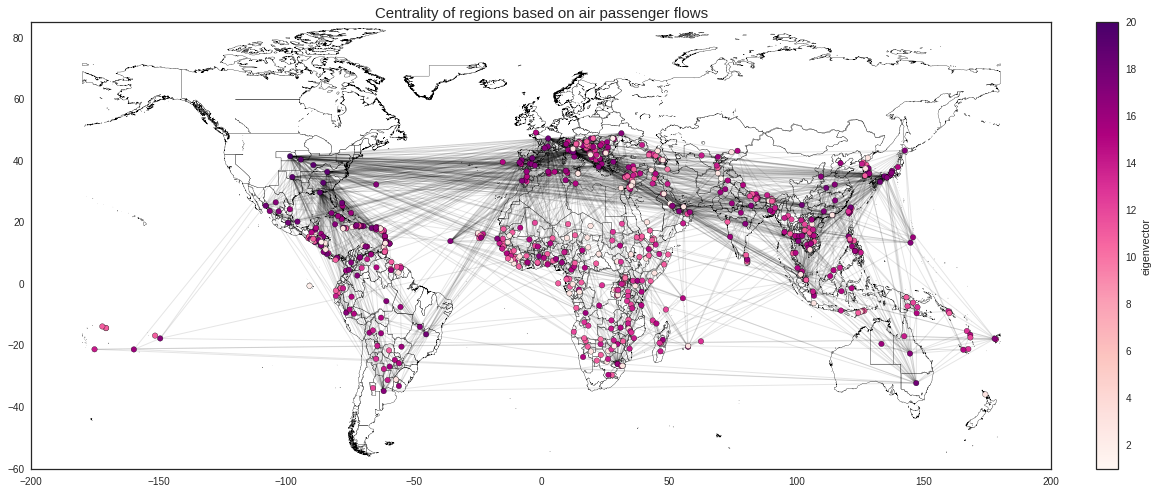

In [26]:
fig, ax = plt.subplots()
for c_l ,patches in dict_mapindex_mpl_polygon.items():
    p = PatchCollection(patches,color='white',lw=.3,edgecolor='k')
    ax.add_collection(p)
ax.autoscale_view()

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
cmap=plt.get_cmap('RdPu')

pos = gdf_model_elements['centroid_largest_landmas'].to_dict()
nc = nx.draw_networkx_nodes(G_travelmatrix,pos=pos,cmap=cmap, with_labels=False, node_size=30, node_color=[i*1 for i in digitized])
#node_size=[i*50000 for i in n_weight.values()])
nx.draw_networkx_edges(G_travelmatrix,pos=pos, width=1, alpha=.1)
# mplleaflet.display(fig=ax.figure)

# plt.gca().set_visible(False)
plt.colorbar(nc, orientation='vertical', label="eigenvector", fraction=0.046, pad=0.04);
ax.set_title('Centrality of regions based on air passenger flows', fontsize=15)
ax.set_ylim([-60, 85])
ax.set_xlim([-200, 200])
fig = plt.gcf()
save_fig(fig, './figs/', 'Eigenvector_centrality_regions_airtravel')
plt.show()

#### Add eigenvector centrality to dataframe for later input-output analysis

In [27]:
gdf_model_elements["e_centrality_flights"] = np.nan
for self_index, self_row_df in gdf_model_elements.iterrows():    
    gdf_model_elements.set_value(self_index, 'e_centrality_flights', n_weight[self_index]) 

In [28]:
gdf_model_elements.columns

Index([        u'Crude_Birth_rate',               u'Messinamea',
                     u'Poverty_WB',   u'adjacmatrix_centrality',
                      u'continent',                  u'country',
                   u'country_code',                 u'geometry',
                            u'lat',                      u'lon',
                     u'perc_pover',               u'population',
                    u'pregnancies',          u'suitability_max',
       u'centroid_largest_landmas',     u'e_centrality_flights'],
      dtype='object')

In [29]:
gdf_map_elements.columns

Index([u'Crude_Birth_rate',       u'Messinamea',       u'Poverty_WB',
              u'continent',          u'country',     u'country_code',
               u'geometry',       u'perc_pover',       u'population',
            u'pregnancies',  u'suitability_max',      u'mpl_polygon'],
      dtype='object')

#### Save Results

In [30]:
gdf_model_elements.reset_index(inplace=True)
gdf_model_elements = gdf_model_elements.drop('centroid_largest_landmas', axis=1)

In [31]:
import os
filename = 'input_data_simulation/geojson/gdf_model_elements.geojson'
try:
    os.remove(filename)
except OSError:
    pass
gdf_model_elements.to_file(filename, driver="GeoJSON")

In [33]:
# Save Air travel matrices
mulitindex_df_Travel_monthly.to_csv(r'input_data_simulation/csv_files/monthly_FlightData.csv')